# LAB 1: VGGNet & ResNet

<h4><div style="text-align: right"> Due date: 15:00 Oct 10, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab1.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[202055623] [허치영]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-10-06 00:42:44.952680


In [2]:
import random
import numpy as np
import torch

# Set the random seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Random seed set to:", seed)

Random seed set to: 0


In [3]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above.
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

if torch.cuda.is_available():
    print("\nGPU information")
    !nvidia-smi
    device = torch.cuda.current_device()
elif torch.mps.device_count() > 0:
    device = 'mps'
else:
    device = torch.device('cpu')

print(device)

Python version
sys.version_info(major=3, minor=8, micro=19, releaselevel='final', serial=0)

OS information
Linux-5.4.0-193-generic-x86_64-with-glibc2.17

Is GPU available?
True

GPU information
Sun Oct  6 00:42:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   33C    P8              16W / 230W |      5MiB

## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>> - **Conv2d -> BatchNorm2d -> ReLU**
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OiTmrplD9gOrEJizLChyLp31R0QtoeHv" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1bBvAOdJeskMMyOrZtBCCnkEEgq9PgjX9" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

In [5]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    # Augmentation
    # : Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data
    # RandomCrop : Crop the given immage at a random location
    transforms.RandomCrop(32, padding=4),
    # RandomHorizontalFlip : Horizontally flip the given image randomly with a given probability
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Normalize : Normalize a tensor image with mean and standard deviation
    # mean: Sequence of means for each channel
    # std: Sequence of standard deviations for each channel
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)

STEP 1: LOADING DATASET
Files already downloaded and verified


In [6]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [7]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [8]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

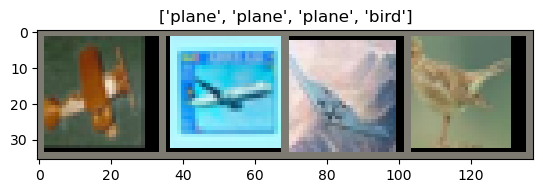

In [11]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=4,
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [12]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

#############
# CODE HERE #
#############


class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        def make_conv_block(in_channels, out_channels, num_conv_layers):
            layers = []
            for _ in range(num_conv_layers):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
                in_channels = out_channels
            return nn.Sequential(*layers)

        self.conv1_x = make_conv_block(3, 64, 2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_x = make_conv_block(64, 128, 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3_x = make_conv_block(128, 256, 3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4_x = make_conv_block(256, 512, 3)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5_x = make_conv_block(512, 512, 3)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layers = nn.Sequential(
            self.conv1_x,
            self.pool1,
            self.conv2_x,
            self.pool2,
            self.conv3_x,
            self.pool3,
            self.conv4_x,
            self.pool4,
            self.conv5_x,
            self.pool5
        )

        self.fc = nn.Linear(512, 3)

    def forward(self, x):
        out = self.conv_layers(x)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

STEP 3: CREATE MODEL CLASS (VGG16)


In [13]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14724675


VGG(
  (conv1_x): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_x): Sequential(
    (0): Conv2d(

In [14]:
def print_layer_output_sizes(model, input_size):
    x = torch.randn(input_size).to(device)
    print(f"Input: {x.shape}")

    for name, layer in model.named_children():
        if name == "conv_layers":
            continue
        print(f"Layer: {name}", end="\t")
        x = layer(x)
        print(f"After : {x.shape}")
        if name == "pool5":
            x = torch.flatten(x, 1)
            print(f"After flatten: {x.shape}")


# Print the output sizes
print_layer_output_sizes(model, (1, 3, 32, 32))

Input: torch.Size([1, 3, 32, 32])
Layer: conv1_x	After : torch.Size([1, 64, 32, 32])
Layer: pool1	After : torch.Size([1, 64, 16, 16])
Layer: conv2_x	After : torch.Size([1, 128, 16, 16])
Layer: pool2	After : torch.Size([1, 128, 8, 8])
Layer: conv3_x	After : torch.Size([1, 256, 8, 8])
Layer: pool3	After : torch.Size([1, 256, 4, 4])
Layer: conv4_x	After : torch.Size([1, 512, 4, 4])
Layer: pool4	After : torch.Size([1, 512, 2, 2])
Layer: conv5_x	After : torch.Size([1, 512, 2, 2])
Layer: pool5	After : torch.Size([1, 512, 1, 1])
After flatten: torch.Size([1, 512])
Layer: fc	After : torch.Size([1, 3])


In [15]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [16]:
logs = {
    "VGGNet": {
        "train_loss": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "avg_inference_time": []
    },
    "ResNet": {
        "train_loss": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "avg_inference_time": []
    }
}

In [17]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

#############
# CODE HERE #
#############

elapsed_time = 0

print(f"Train on {device}")
for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate train Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct.item() / total
    # Log
    logs["VGGNet"]["train_loss"].append(epoch_loss)
    logs["VGGNet"]["train_accuracy"].append(epoch_accuracy)


    # Calculate Accuracy on test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_inference_time = 0
    with torch.no_grad():
        # Iterate through test dataset
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            inference_start = time.time()
            # Forward pass only to get logits/output
            outputs = model(images)

            total_inference_time += time.time() - inference_start

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted == labels).sum()

    test_accuracy = 100 * correct.item() / total
    avg_inference_time = total_inference_time / len(test_loader)
    logs["VGGNet"]["test_accuracy"].append(test_accuracy)
    logs["VGGNet"]["avg_inference_time"].append(avg_inference_time)

    # print Loss, Accuracy, Time
    elapsed_time = time.time() - start_time
    print(f"Epochs: {epoch} Loss: {epoch_loss}. Accuracy: {test_accuracy}. Elapsed time: {elapsed_time} sec")




STEP 7: TRAIN THE MODEL
Train on 0
Epochs: 0 Loss: 0.6646595117399248. Accuracy: 83.33333333333333. Elapsed time: 2.2641494274139404 sec
Epochs: 1 Loss: 0.4029371746010699. Accuracy: 86.26666666666667. Elapsed time: 2.020634651184082 sec
Epochs: 2 Loss: 0.30414451936543996. Accuracy: 88.1. Elapsed time: 1.9872641563415527 sec
Epochs: 3 Loss: 0.25127578211032736. Accuracy: 88.73333333333333. Elapsed time: 2.024995803833008 sec
Epochs: 4 Loss: 0.20014839512059243. Accuracy: 90.3. Elapsed time: 1.968665361404419 sec
Epochs: 5 Loss: 0.1600615997814526. Accuracy: 90.5. Elapsed time: 1.9986789226531982 sec
Epochs: 6 Loss: 0.13865721636151862. Accuracy: 91.96666666666667. Elapsed time: 1.9908876419067383 sec
Epochs: 7 Loss: 0.10666207315684376. Accuracy: 90.7. Elapsed time: 1.9870171546936035 sec
Epochs: 8 Loss: 0.08169462737800964. Accuracy: 92.53333333333333. Elapsed time: 2.036972761154175 sec
Epochs: 9 Loss: 0.0706209278847012. Accuracy: 91.83333333333333. Elapsed time: 2.081054449081421 

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br>
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br>
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points]

In [18]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')
#############
# CODE HERE #
#############


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv_stack(x)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        def make_convn_x(n_blocks, in_channels, hidden_channels, out_channels, stride=1):
            blocks = []
            for i in range(n_blocks):
                if i == 0:
                    blocks.append(ResidualBlock(in_channels, hidden_channels, out_channels, stride=stride))
                else:
                    blocks.append(ResidualBlock(out_channels, hidden_channels, out_channels, stride=1))

            return nn.Sequential(*blocks)

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2_x = make_convn_x(3, 64, 64, 256, stride=1)
        self.conv3_x = make_convn_x(4, 256, 128, 512, stride=2)
        self.conv4_x = make_convn_x(6, 512, 256, 1024, stride=2)
        self.conv5_x = make_convn_x(3, 1024, 512, 2048, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 3)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out


print('STEP 4: INSTANTIATE MODEL CLASS')
#############
# CODE HERE #
#############

model = ResNet()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
#######################
#  USE GPU FOR MODEL  #
#######################

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  23533059


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): ResidualBlock(
      (conv_stack): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [19]:
def print_layer_output_sizes(model, input_size):
    x = torch.randn(input_size).to(device)
    print(f"Input: {x.shape}")

    for name, layer in model.named_children():
        print(f"Layer: {name}", end="\t")
        x = layer(x)
        print(f"After : {x.shape}")
        if name == "avgpool":
            x = torch.flatten(x, 1)
            print(f"After flatten: {x.shape}")


# Print the output sizes
print_layer_output_sizes(model, (1, 3, 32, 32))

Input: torch.Size([1, 3, 32, 32])
Layer: conv1	After : torch.Size([1, 64, 32, 32])
Layer: conv2_x	After : torch.Size([1, 256, 32, 32])
Layer: conv3_x	After : torch.Size([1, 512, 16, 16])
Layer: conv4_x	After : torch.Size([1, 1024, 8, 8])
Layer: conv5_x	After : torch.Size([1, 2048, 4, 4])
Layer: avgpool	After : torch.Size([1, 2048, 1, 1])
After flatten: torch.Size([1, 2048])
Layer: fc	After : torch.Size([1, 3])


### 2.2 Print test accuracy for every epochs. [1 points]

In [20]:
print('STEP 5: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
#############
# CODE HERE #
#############

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

print('STEP 7: TRAIN THE MODEL')
num_epochs = 15

#############
# CODE HERE #
#############

elapsed_time = 0

print(f"Train on {device}")
for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate train Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct.item() / total
    # Log
    logs["ResNet"]["train_loss"].append(epoch_loss)
    logs["ResNet"]["train_accuracy"].append(epoch_accuracy)


    # Calculate Accuracy on test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_inference_time = 0
    with torch.no_grad():
        # Iterate through test dataset
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            inference_start = time.time()
            # Forward pass only to get logits/output
            outputs = model(images)

            total_inference_time += time.time() - inference_start

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted == labels).sum()

    test_accuracy = 100 * correct.item() / total
    avg_inference_time = total_inference_time / len(test_loader)
    logs["ResNet"]["test_accuracy"].append(test_accuracy)
    logs["ResNet"]["avg_inference_time"].append(avg_inference_time)

    # print Loss, Accuracy, Time
    elapsed_time = time.time() - start_time
    print(f"Epochs: {epoch} Loss: {epoch_loss}. Accuracy: {test_accuracy}. Elapsed time: {elapsed_time} sec")




STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Train on 0
Epochs: 0 Loss: 1.2667867238238706. Accuracy: 76.3. Elapsed time: 12.5814049243927 sec
Epochs: 1 Loss: 0.5998226234973487. Accuracy: 82.46666666666667. Elapsed time: 12.46222710609436 sec
Epochs: 2 Loss: 0.47652641241833316. Accuracy: 85.5. Elapsed time: 12.455680847167969 sec
Epochs: 3 Loss: 0.403814393206168. Accuracy: 86.3. Elapsed time: 12.446835041046143 sec
Epochs: 4 Loss: 0.3338732386039475. Accuracy: 86.73333333333333. Elapsed time: 12.465787887573242 sec
Epochs: 5 Loss: 0.299885336877936. Accuracy: 83.33333333333333. Elapsed time: 12.488388299942017 sec
Epochs: 6 Loss: 0.25953070150088453. Accuracy: 87.6. Elapsed time: 12.481881380081177 sec
Epochs: 7 Loss: 0.2005532746976715. Accuracy: 89.0. Elapsed time: 12.48839807510376 sec
Epochs: 8 Loss: 0.17694248830489182. Accuracy: 88.66666666666667. Elapsed time: 12.491106986999512 sec
Epochs: 9 Loss: 0.13255160721808168. Accuracy: 8

In [21]:
print(logs)
from matplotlib.ticker import MaxNLocator

{'VGGNet': {'train_loss': [0.6646595117399248, 0.4029371746010699, 0.30414451936543996, 0.25127578211032736, 0.20014839512059243, 0.1600615997814526, 0.13865721636151862, 0.10666207315684376, 0.08169462737800964, 0.0706209278847012, 0.06760962767589648, 0.04413312650088347, 0.04854485651446601, 0.03594060459418885, 0.029301948823681954, 0.028712890199701285, 0.04190185972907722, 0.013201053506868371, 0.02491434709607008, 0.048895686166360974], 'train_accuracy': [73.88666666666667, 84.30666666666667, 88.10666666666667, 90.2, 92.17333333333333, 93.74666666666667, 94.62666666666667, 95.89333333333333, 97.05333333333333, 97.37333333333333, 97.38, 98.45333333333333, 98.12666666666667, 98.58666666666667, 98.88666666666667, 99.04, 98.6, 99.53333333333333, 99.10666666666667, 98.34], 'test_accuracy': [83.33333333333333, 86.26666666666667, 88.1, 88.73333333333333, 90.3, 90.5, 91.96666666666667, 90.7, 92.53333333333333, 91.83333333333333, 92.36666666666666, 91.0, 92.76666666666667, 91.83333333333

In [22]:
def plot_train_accuracy_loss(logs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(logs["VGGNet"]["train_accuracy"], label="VGGNet")
    plt.plot(logs["ResNet"]["train_accuracy"], label="ResNet")
    plt.title("Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1, 2, 2)
    plt.plot(logs["VGGNet"]["train_loss"], label="VGGNet")
    plt.plot(logs["ResNet"]["train_loss"], label="ResNet")
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.savefig("train_accuracy_loss.pdf")
    plt.tight_layout()
    plt.show()

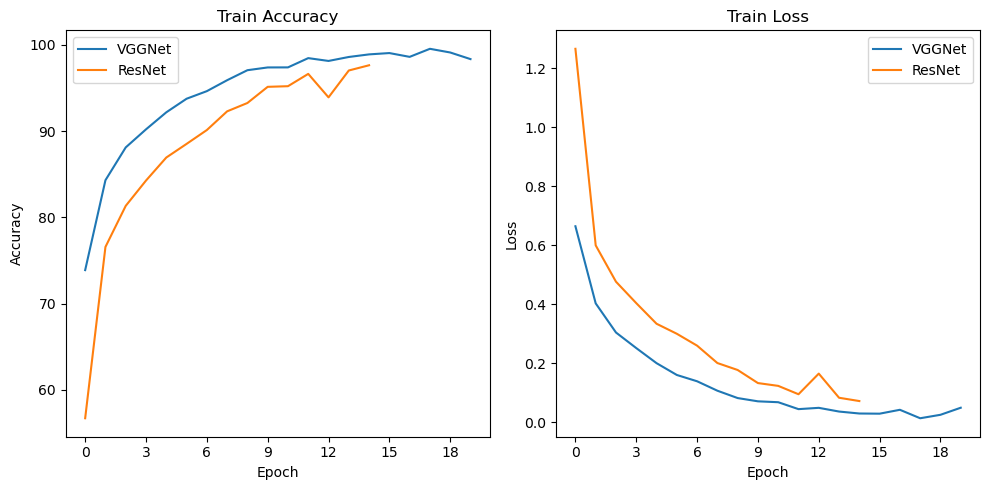

In [23]:
plot_train_accuracy_loss(logs)

In [24]:
def plot_test_accuracy(logs):
    plt.figure(figsize=(10, 5))
    plt.plot(logs["VGGNet"]["test_accuracy"], label="VGGNet")
    plt.plot(logs["ResNet"]["test_accuracy"], label="ResNet")
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.savefig("test_accuracy.pdf")
    plt.show()

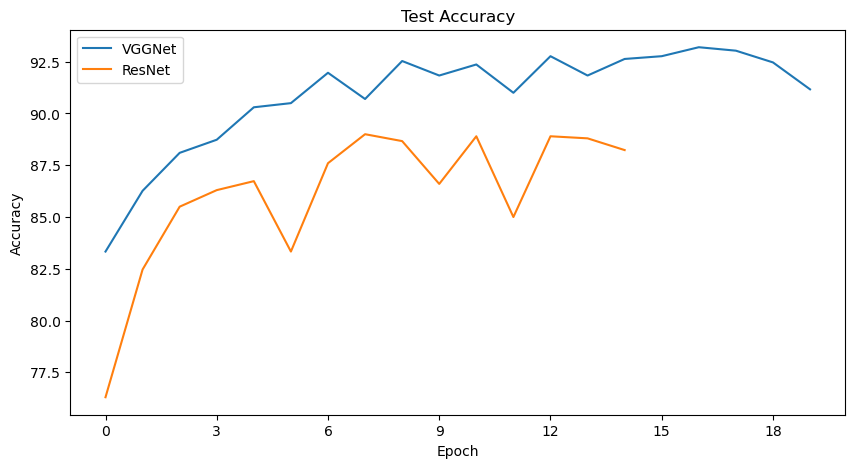

In [25]:
plot_test_accuracy(logs)

In [26]:
def plot_inference_time(logs):
    plt.figure(figsize=(10, 5))
    plt.plot(logs["VGGNet"]["avg_inference_time"], label="VGGNet")
    plt.plot(logs["ResNet"]["avg_inference_time"], label="ResNet")
    plt.title("Average Inference Time")
    plt.xlabel("Epoch")
    plt.ylabel("Time (sec)")
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.savefig("inference_time.pdf")
    plt.show()

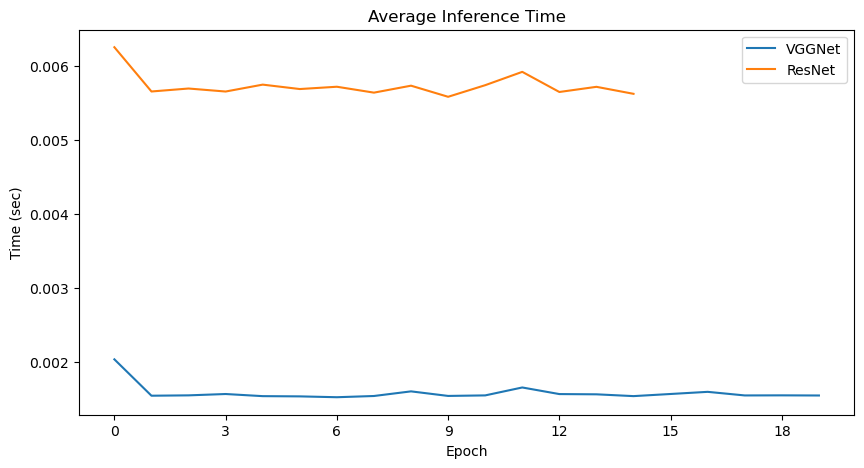

In [27]:
plot_inference_time(logs)